In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, make_scorer, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, recall_score, f1_score, average_precision_score

from scipy import interp
from xgboost import XGBClassifier

from database.utils import get_train_test_data
from pipelines.feature_extractor import get_feature_extractor
from pipelines.models import get_ensemble_model
from nlp.glove import Glove
from evaluation.metrics import *

from copy import deepcopy
import numpy as np
import pandas as pd
import pprint
import time

import matplotlib.pyplot as plt
from itertools import cycle

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [5]:
glove = Glove.load()
w2v = glove.get_dict()
feature_extractor = get_feature_extractor(w2v)

In [6]:
ensemble = get_ensemble_model(w2v)
ensemble.steps = ensemble.steps[2:]

In [17]:
Xr_train, y_train, Xr_test, y_test = get_train_test_data(merge=True)

cols_target = ['label_pa', 'label_sb', 'label_sleep']
print('Total rows in test is {}'.format(len(X_test)))
print('Total rows in train is {}'.format(len(X_train)))
print(y_train[cols_target].sum())

Total rows in test is 2213
Total rows in train is 8070
label_pa       1259.0
label_sb       1535.0
label_sleep     411.0
dtype: float64


## Multilabel

In [7]:
Xr_train, y_train, Xr_test, y_test = get_train_test_data(merge=True)

models = [("lr", OneVsRestClassifier(LogisticRegression(C=0.1, penalty='l2', solver='lbfgs', n_jobs=-1))),
          ("nb", OneVsRestClassifier(BernoulliNB(alpha=5.0))),
          ("rf", OneVsRestClassifier(RandomForestClassifier(n_estimators=300, 
                                                            max_depth=10,
                                                            min_samples_split=5,
                                                            n_jobs=-1))),
          ("xgb", OneVsRestClassifier(XGBClassifier(n_estimators=150,
                                                    max_depth=8,
                                                    n_jobs=8))),
          ("et", OneVsRestClassifier(ExtraTreesClassifier(n_estimators=300,
                                                          max_depth=10,
                                                          min_samples_split=10,
                                                          n_jobs=-1))),
          ("ensemble", OneVsRestClassifier(ensemble)),
           #("svm", SVC(C=100, gamma=0.0001, probability=True)),
         ]

results = {}

X_train = feature_extractor.fit_transform(Xr_train, y_train['label_pa'])
X_test = feature_extractor.transform(Xr_test)

for name, classifier in models:
    print(name)
    results[name] = {}

    cv = StratifiedKFold(n_splits=5, random_state=42)
    
    train_times = []
    predict_times = []
        
    ts = time.time()
    classifier.fit(X_train, y_train)
    te = time.time()
    train_times.append(te - ts)
    
    y_scores_test = classifier.predict_proba(X_test)
    ts = time.time()
    y_pred_test = classifier.predict(X_test)
    te = time.time()
    predict_times.append(te - ts)
    
    measures, tpr, fpr, roc_auc = class_report_multilabel(y_test, y_scores_test)
    for metric in measures:
        results[name][metric] = measures[metric]
        
    results[name]['train_time'] = np.mean(train_times)
    results[name]['predict_time'] = np.mean(predict_times)

/home/vmadmin/pass/database/utils.py:33: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  train = pd.concat((train_sleep, train_sb, train_pa), ignore_index=True)#, sort=False)
/home/vmadmin/pass/database/utils.py:35: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  test = pd.concat((test_sleep, test_sb, test_pa), ignore_index=True)#, sort=False)


lr
ROC AUC for class 0: 0.96
Precision for class 0: 0.70
ROC AUC for class 1: 0.81
Precision for class 1: 0.45
ROC AUC for class 2: 0.97
Precision for class 2: 0.59
Average precision score, micro-averaged over all classes: 0.56
Test score: 0.88

nb
ROC AUC for class 0: 0.94
Precision for class 0: 0.64
ROC AUC for class 1: 0.79
Precision for class 1: 0.41
ROC AUC for class 2: 0.96
Precision for class 2: 0.54
Average precision score, micro-averaged over all classes: 0.52
Test score: 0.87

rf
ROC AUC for class 0: 0.96
Precision for class 0: 0.78
ROC AUC for class 1: 0.88
Precision for class 1: 0.65
ROC AUC for class 2: 0.91
Precision for class 2: 0.67
Average precision score, micro-averaged over all classes: 0.69
Test score: 0.91

xgb
ROC AUC for class 0: 0.98
Precision for class 0: 0.87
ROC AUC for class 1: 0.90
Precision for class 1: 0.68
ROC AUC for class 2: 0.96
Precision for class 2: 0.77
Average precision score, micro-averaged over all classes: 0.76
Test score: 0.93

et
ROC AUC for 

In [20]:
measures, tpr, fpr, roc_auc = class_report_multilabel(y_test, y_scores_test)

ROC AUC for class 0: 0.97
Precision for class 0: 0.85
ROC AUC for class 1: 0.89
Precision for class 1: 0.68
ROC AUC for class 2: 0.98
Precision for class 2: 0.79
Average precision score, micro-averaged over all classes: 0.72
Test score: 0.93



In [18]:
pd.DataFrame(results).T

,accuracy,avg_precision,f1score,precision,predict_time,recall,specificity,test_roc_auc,train_time
ensemble,0.773610,0.719650,0.629875,0.772563,4.088608,0.531677,0.978402,0.932769,178.070619
et,0.704474,0.657407,0.391829,0.775735,1.594360,0.262112,0.989544,0.907190,9.218364
lr,0.706281,0.562238,0.533143,0.625418,0.005736,0.464596,0.961604,0.884803,7.631845
nb,0.609128,0.519326,0.582977,0.472265,0.183100,0.761491,0.882585,0.869671,0.352456
rf,0.739720,0.692872,0.548866,0.740506,1.851367,0.436025,0.978917,0.910569,11.020338
xgb,0.776322,0.763579,0.646766,0.755814,0.914997,0.565217,0.974803,0.934096,72.181396


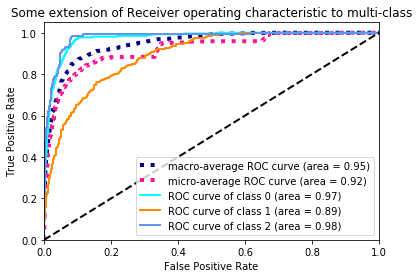

In [21]:
lw = 2
n_classes = 3

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)


colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

## Separating each indicator

In [37]:
%%time

train_test_data = get_train_test_data()

models = [("lr", LogisticRegression(C=0.1, penalty='l2', solver='lbfgs', n_jobs=-1)),
           ("nb", BernoulliNB(alpha=5.0)),
           ("rf", RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_split=5, n_jobs=-1)),
           ("xgb", XGBClassifier(n_estimators=300, max_depth=8, n_jobs=-1)),
           ("et", ExtraTreesClassifier(n_estimators=300, max_depth=10, min_samples_split=10, n_jobs=-1)),
           #("svm", SVC(C=100, gamma=0.0001, probability=True)),
           ("ensemble", ensemble),
         ]

results = {}

for Xr_train, y_train, Xr_test, y_test, indicator in train_test_data:
    X_train = feature_extractor.fit_transform(Xr_train, y_train)
    X_test = feature_extractor.transform(Xr_test)
            
    print(indicator, X_train.shape)
    
    results[indicator] = {}
    for name, classifier in models:
        results[indicator][name] = {}
        
        cv = StratifiedKFold(n_splits=5, random_state=42)
        scores = []
        conf_mat = np.zeros((2, 2))      # Binary classification
        false_pos = set()
        false_neg = set()
        train_times = []
        predict_times = []
        
        for dev_i, val_i in cv.split(X_train, y_train):
            clf = deepcopy(classifier)
            X_dev, X_val = X_train[dev_i], X_train[val_i]
            y_dev, y_val = y_train[dev_i], y_train[val_i]
            ts = time.time()

            clf.fit(X_dev, y_dev)
            te = time.time()
            
            train_times.append(te - ts)
            
            ts = time.time()
            y_pprobs = clf.predict_proba(X_val)       # Predicted probabilities
            te = time.time()
            
            predict_times.append(te - ts)
            
            y_plabs = np.squeeze(clf.predict(X_val))  # Predicted class labels

            scores.append(roc_auc_score(y_val, y_pprobs[:, 1]))
            #fpr, tpr, _ = roc_curve(y_true)
            
            confusion = confusion_matrix(y_val, y_plabs)
            conf_mat += confusion


        classifier.fit(X_train, y_train)
        y_scores_test = classifier.predict_proba(X_test)
        y_pred_test = classifier.predict(X_test)
        
        # Collect indices of false positive and negatives
        fp_i = np.where((y_pred_test == 1) & (y_test == 0))[0]
        fn_i = np.where((y_pred_test == 0) & (y_test == 1))[0]
        false_pos.update(Xr_test[fp_i])
        false_neg.update(Xr_test[fn_i])
        
        mean_roc_auc = np.mean(scores)
        test_roc_auc = roc_auc_score(y_test, y_scores_test[:, 1])        
        
        results[indicator][name]['test_roc_auc'] = test_roc_auc        
            
        print("\n[%s][%s] Mean score: %0.2f (+/- %0.2f)" % (indicator, name, mean_roc_auc, np.std(scores) * 2))
        print("\n[%s][%s] Test score: %0.2f" % (indicator, name, test_roc_auc))
        
        #conf_mat /= 5
        #print("Mean CM: \n", conf_mat)
        #print("\nMean classification measures: \n")
        measures = class_report(conf_mat)
        for metric in measures:
            results[indicator][name][metric] = measures[metric]
        
        results[indicator][name]['mean_roc_auc'] = np.mean(scores)
        results[indicator][name]['std_roc_auc'] = np.std(scores) * 2
        results[indicator][name]['train_time'] = np.mean(train_times)
        results[indicator][name]['predict_time'] = np.mean(predict_times)
        
        #pprint.pprint(measures)

sleep (1146, 1087)

[sleep][lr] Mean score: 0.76 (+/- 0.08)

[sleep][lr] Test score: 0.67

[sleep][nb] Mean score: 0.89 (+/- 0.14)

[sleep][nb] Test score: 0.74

[sleep][rf] Mean score: 0.88 (+/- 0.12)

[sleep][rf] Test score: 0.77
sedentary_behaviour (4294, 1760)

[sedentary_behaviour][lr] Mean score: 0.73 (+/- 0.08)

[sedentary_behaviour][lr] Test score: 0.71

[sedentary_behaviour][nb] Mean score: 0.79 (+/- 0.14)

[sedentary_behaviour][nb] Test score: 0.74

[sedentary_behaviour][rf] Mean score: 0.78 (+/- 0.17)

[sedentary_behaviour][rf] Test score: 0.79
physical_activity (2630, 2884)

[physical_activity][lr] Mean score: 0.81 (+/- 0.21)

[physical_activity][lr] Test score: 0.82

[physical_activity][nb] Mean score: 0.83 (+/- 0.30)

[physical_activity][nb] Test score: 0.79

[physical_activity][rf] Mean score: 0.87 (+/- 0.26)

[physical_activity][rf] Test score: 0.86
CPU times: user 5min 6s, sys: 2min 15s, total: 7min 22s
Wall time: 2min 58s


In [21]:
pd.DataFrame(results['physical_activity']).T

,accuracy,f1score,mean_roc_auc,precision,sensitivity,specificity,std_roc_auc,train_time
ensemble,0.951934,0.975319,0.902961,1.000000,0.951827,1.000000,0.067394,9.435405
et,0.948066,0.973341,0.839654,0.998255,0.949640,0.000000,0.110316,2.243759
lr,0.953591,0.976000,0.879777,0.993601,0.959012,0.620690,0.063690,0.793034
nb,0.957459,0.977969,0.970510,0.994183,0.962275,0.705882,0.033964,0.008714
rf,0.949171,0.973878,0.881364,0.997673,0.951192,0.428571,0.095110,2.445561
svm,0.951934,0.975319,0.855466,1.000000,0.951827,1.000000,0.061755,0.966141
xgb,0.949724,0.974126,0.856645,0.996510,0.952725,0.500000,0.073139,3.182969


In [43]:
pd.DataFrame(results['sedentary_behaviour']).T

,accuracy,f1score,mean_roc_auc,precision,sensitivity,specificity,std_roc_auc,train_time
ensemble,0.937127,0.966639,0.904497,0.996084,0.938884,0.880000,0.187142,12.326693
et,0.934739,0.965517,0.860333,0.999130,0.934093,0.963636,0.234821,2.352192
lr,0.932750,0.964081,0.872131,0.986945,0.942252,0.716981,0.153806,0.926467
nb,0.958615,0.977547,0.927240,0.985205,0.970009,0.810056,0.157551,0.016102
rf,0.935137,0.965691,0.854135,0.998259,0.935181,0.933333,0.255848,2.608832
svm,0.929964,0.962885,0.856396,0.993473,0.934124,0.782609,0.156780,4.435725
xgb,0.935535,0.965823,0.900458,0.996084,0.937346,0.873239,0.162439,5.330778


In [44]:
pd.DataFrame(results['sleep']).T

,accuracy,f1score,mean_roc_auc,precision,sensitivity,specificity,std_roc_auc,train_time
ensemble,0.928571,0.962445,0.918315,0.991899,0.934690,0.640000,0.048971,9.363486
et,0.930233,0.963510,0.902579,0.998200,0.931150,0.846154,0.039138,2.297962
lr,0.930233,0.963190,0.867390,0.989199,0.938514,0.636364,0.041203,0.737107
nb,0.937708,0.966048,0.948957,0.960396,0.971767,0.584906,0.018239,0.007519
rf,0.928571,0.962641,0.897460,0.997300,0.930311,0.769231,0.063915,2.426127
svm,0.927741,0.962256,0.858036,0.998200,0.928811,0.800000,0.041497,0.939432
xgb,0.926080,0.960982,0.862861,0.986499,0.936752,0.558824,0.025773,3.227897
